In [ ]:
# Reproducible Analysis

## CASA0013: Foundations of Spatial Data Science

### Student Ids: ucfnlui, ucftYYYY, etc.

In [ ]:
### ucfnlui code:

In [1]:
print("start from here")

start from here


In [ ]:
### ucfniul code:

In [ ]:
print("start from here")

In [1]:
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
#Read in data of airbnb listings and london boroughs
data = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/visualisations/listings.csv")
#print(data.head())
data.set_index('id', inplace=True)
london = gpd.read_file("http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/visualisations/neighbourhoods.geojson", drivers='GPKG')

epsg:4326


<AxesSubplot:>

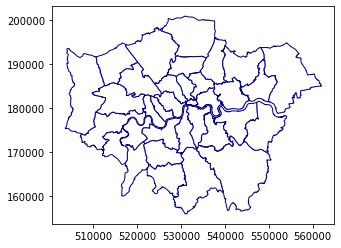

In [3]:
#Change the crs and plot london borough to check the data
print(london.crs)
london = london.to_crs('epsg:27700')
london.plot(facecolor='white', edgecolor='darkblue')

<AxesSubplot:>

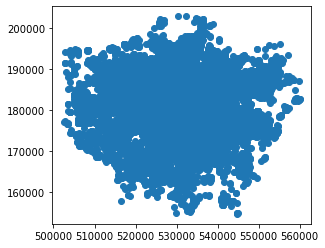

In [4]:
#Converting listings to a geodataframe by using the coordinates
gdf = gpd.GeoDataFrame(data, 
            geometry=gpd.points_from_xy(
                        data['longitude'], 
                        data['latitude'], 
                        crs='epsg:4326'
            )
      )
#Change the crs and plot
gdf = gdf.to_crs('epsg:27700')
gdf.plot()

In [ ]:
#Download the OSM data:
#It can be very slow sometimes, so it may be better to copy the link and download the data by hand.
#!wget http://download.geofabrik.de/europe/great-britain/england/greater-london-latest-free.shp.zip
#!unzip -d /greater-london-latest-free greater-london-latest-free.shp.zip

--2023-01-05 15:52:50--  http://download.geofabrik.de/europe/great-britain/england/greater-london-latest-free.shp.zip
Resolving download.geofabrik.de (download.geofabrik.de)... 65.109.50.43, 65.109.48.72
Connecting to download.geofabrik.de (download.geofabrik.de)|65.109.50.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148028926 (141M) [application/zip]
Saving to: ‘greater-london-latest-free.shp.zip’

.shp.zip             12%[=>                  ]  17.32M  2.43MB/s    eta 52s    

<AxesSubplot:>

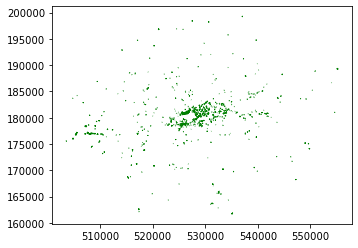

In [5]:
osm = gpd.read_file('greater-london-latest-free/gis_osm_pois_a_free_1.shp')
#Extract hotels location data, change to the same crs and plot
hotel = osm[(osm.fclass == 'hotel')]
hotel = hotel.to_crs('epsg:27700')
hotel.plot(edgecolor='green')

<AxesSubplot:>

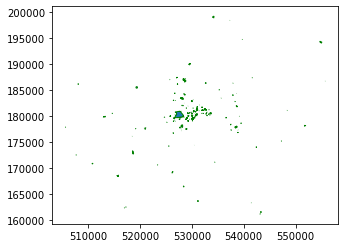

In [7]:
#Extract attractions location data, change to the same crs and plot
attractions = osm[(osm.fclass == 'attraction')]
attractions = attractions.to_crs('epsg:27700')
attractions.plot(edgecolor='green')

<AxesSubplot:>

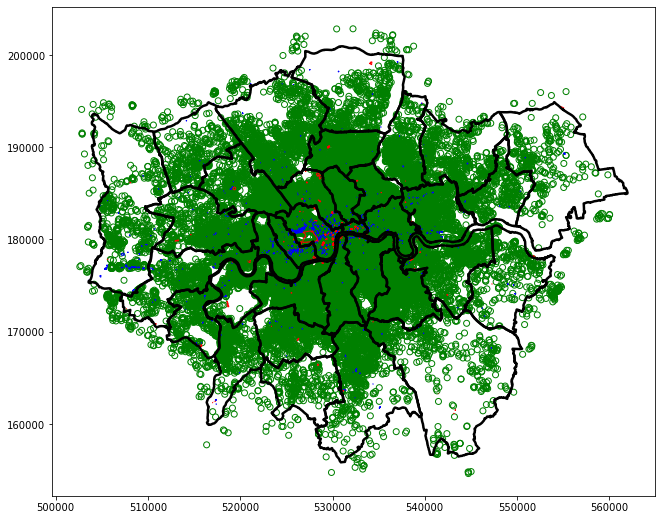

In [8]:
#Put everything in the same map to observe their locations. 
#I notice there are much more airbnb listings than hotels, with much broader scales.
#This part may take around 2 minutes to run
fig, ax = plt.subplots(1,1, figsize=(12,9))
gdf.plot(edgecolor="green", facecolor='none', ax=ax)
hotel.plot(edgecolor="blue", facecolor='none', ax=ax)
attractions.plot(edgecolor="red", facecolor='none', ax=ax)
london.plot(edgecolor="black", facecolor='none', linewidth=2.5, ax=ax)

<AxesSubplot:ylabel='Frequency'>

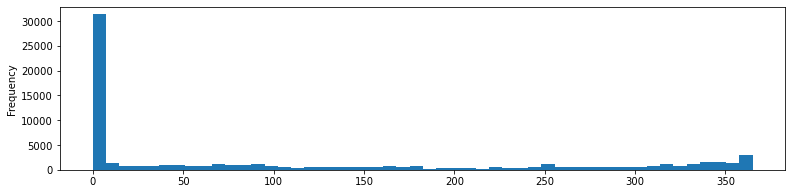

In [9]:
#Check the availabity of listings in 365 days. 
gdf.availability_365.plot.hist(bins=50, figsize=(13,3))
#Most of the listings are occupied most of the year

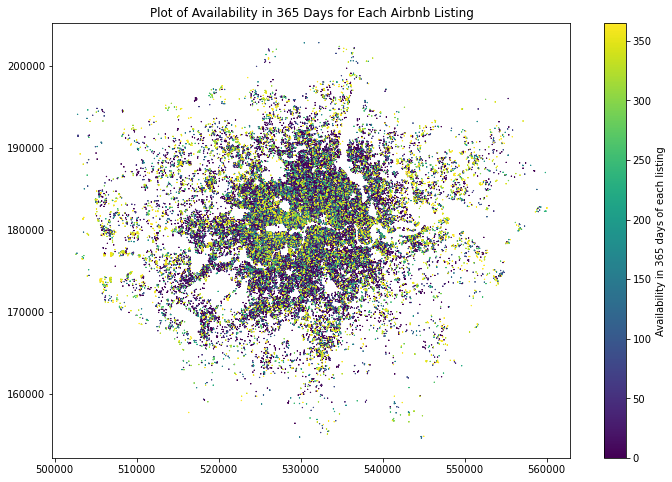

In [56]:
#Plot the listings and mark them with the availability data
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='availability_365', cmap='viridis', 
         legend=True, legend_kwds={'label':'Availability in 365 days of each listing'});
ax.set_title("Plot of Availability in 365 Days for Each Airbnb Listing");

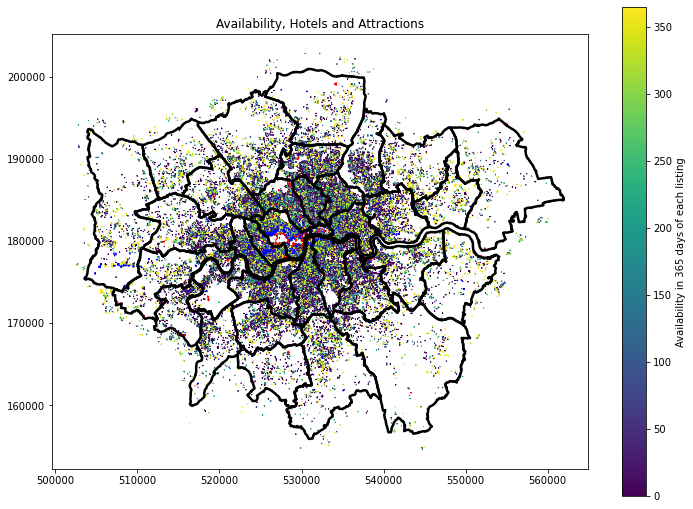

In [68]:
#Put everything together to see if the availability is related to the location of hotels and attractions.
#This part may also take around 2 minutes to run
fig, ax = plt.subplots(1,1, figsize=(12,9))
gdf.plot(marker='*', markersize=0.25, 
         column='availability_365', cmap='viridis', 
         legend=True, legend_kwds={'label':'Availability in 365 days of each listing'}, ax=ax)
hotel.plot(edgecolor="blue", facecolor='none', ax=ax)
attractions.plot(edgecolor="red", facecolor='none', ax=ax)
london.plot(edgecolor="black", facecolor='none', linewidth=2.5, ax=ax)
ax.set_title("Availability, Hotels and Attractions")
plt.savefig('availability, hotels, and attractions.png', dpi=150)

In [ ]:
### ucfnply code:

In [ ]:
print("start from here")

In [ ]:
### ucfnjin code:

In [ ]:
print("start from here")